In [44]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
from Utilities import pareto_front, compute_hypervolume
import matplotlib.pyplot as plt

font = {'size': 14}
plt.rc('font', **font)

In [25]:
problem_names = ["ZDT1", "WFG4", "DTLZ7"]
algos = ["GP", "MOTPE", "GP_MOTPE"]
seeds = [8, 23, 45, 98, 123, 124, 139, 147, 458, 1990, 4554, 5548, 85669] 
initial_point = 54
analytical_functions = {}

for id_algo in algos:
    
    problems = {}
    for id_problem in problem_names:
        
        HV_storage = np.zeros((101, len(seeds)))
        id_rs = -1
        for random_seed in seeds:
            id_rs += 1
            if random_seed == 1990:
                seed_info = ""
                l = 1.0
            else:
                seed_info = "_s_" + str(random_seed)
                l = 1
            
            if id_problem == "WFG4":
                g = 0.1
                ref_point = [3, 5]
            else:
                g = 0.3
                if id_problem == "ZDT1":
                    ref_point = [1, 10]
                else:
                    ref_point = [1, 23]

            if id_algo == "GP":
                path_file_obj = "../output/GP_sklearn/meanObjectives_GP_"+ id_problem+ seed_info + ".csv"
            elif id_algo == "GP_MOTPE":
                path_file_obj = "../output/parameter_exploration_GP_MOTPE/meanObjectives_GP_"+id_problem+"_gamma_"+str(g)+"_l_"+str(l)+seed_info +".csv"
            else:
                path_file_obj = "../output/MOTPE_sklearn/meanObjectives_MOTPE_"+id_problem+"_g_"+str(g)+seed_info +".csv"

            data_file_o = pd.read_csv(path_file_obj, sep=',', header=0).values[:,1:]

            # Compute the HV on each infill point
            hv_temp = []
            for index in range(initial_point, data_file_o.shape[0]+1):
                pf = pareto_front(data_file_o[:index, :], index=True)
                pf = data_file_o[pf]
                volumen = compute_hypervolume(pf, ref_point)
                hv_temp.append(volumen)
                
            # Save the HV evolution of this random seed
            HV_storage[:, id_rs] = hv_temp
            
        # Save the HV evolution of each macro replication of this problem   
        problems[id_problem] ={
            "HV": np.asarray(HV_storage)
        }
    # Save all the analysis of this algorithm
    analytical_functions[id_algo] = problems

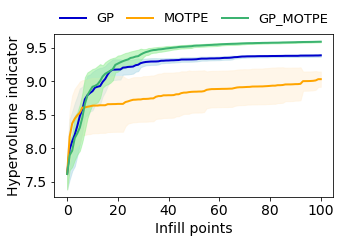

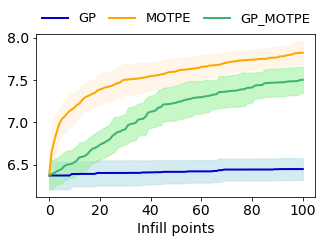

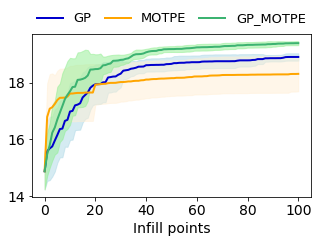

In [50]:
colors = ["mediumblue", "orange", "mediumseagreen"]
shadow = ["lightblue", "papayawhip", "lightgreen"]
for id_problem in range(len(problem_names)):
    plt.figure(figsize=(5, 3))
    
    for id_algo in range(len(algos)):
        data = analytical_functions[algos[id_algo]][problem_names[id_problem]]["HV"]
#         print(data)
        
        mean = np.mean(data, axis=1)
        std = np.std(data, axis = 1)
#         print(mean)
#         print(std)
        X_low = mean - 1*np.abs(std)
        X_upper = mean + 1*np.abs(std)
        
        plt.plot(mean, color=colors[id_algo], linestyle='-', 
         linewidth=2, markersize=12, label=algos[id_algo])
        plt.fill_between(np.asarray(range(len(mean))), X_low, X_upper, 
                 color=shadow[id_algo],  alpha=0.5)
    
    if id_problem==0:
        plt.ylabel("Hypervolume indicator")
    plt.xlabel("Infill points")
    plt.legend()
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
                      ncol=3, mode="expand", borderaxespad=0., frameon=False,
              fontsize=13)
    
    plt.savefig('..\output\plots\hv_evolution_'+problem_names[id_problem]+'.pdf', dpi=1200, bbox_inches='tight')